<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-2)" data-toc-modified-id="Общее-впечатление-(ревью-2)-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 2)</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Insalling-and-checking-data" data-toc-modified-id="Insalling-and-checking-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Insalling and checking data</a></span></li><li><span><a href="#Embedding" data-toc-modified-id="Embedding-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Embedding</a></span></li><li><span><a href="#Imbalance-classes" data-toc-modified-id="Imbalance-classes-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Imbalance classes</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Catboost</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from tqdm import notebook
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.utils import resample, shuffle
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from pymystem3 import Mystem
import re
import warnings
from catboost import CatBoostClassifier

In [2]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Insalling and checking data

In [3]:
try:
    data = pd.read_csv('toxic_comments.csv')
except:
    data = pd.read_csv('/datasets/toxic_comments.csv')

In [4]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


<AxesSubplot:>

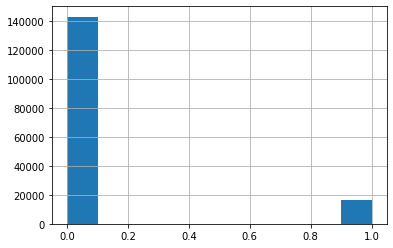

In [5]:
data['toxic'].hist()

In [6]:
data['toxic'].mean()

0.10161213369158527

В данных наблюдается несбалансированность классов

In [9]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    word_list = nltk.word_tokenize(text)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized_output

In [10]:
data['lemm'] = data['text'].apply(lemmatize_text) #лемматизация
data = data.drop(columns='text')

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   toxic       159292 non-null  int64 
 2   lemm        159292 non-null  object
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


## Imbalance classes

In [12]:
y = data['toxic']
X = data.drop(['toxic'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords)

X_train = count_tf_idf.fit_transform(X_train['lemm'].values)
X_test = count_tf_idf.transform(X_test['lemm'].values)
print(X_train.shape)
print(X_test.shape)
cv_counts = 3

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(95575, 135558)
(63717, 135558)


In [13]:
data_train = data.iloc[y_train.index]

y_train_class_zero = data_train[data_train['toxic'] == 0]['toxic']
y_train_class_one = data_train[data_train['toxic'] == 1]['toxic']

In [14]:
y_train_class_zero_downsample = y_train_class_zero.sample(y_train_class_one.shape[0], random_state=1)
y_train_downsample = pd.concat([y_train_class_zero_downsample, y_train_class_one])

X_train_downsample = data.iloc[y_train_downsample.index]
X_train_downsample, y_train_downsample = shuffle(X_train_downsample, y_train_downsample, random_state=1)
X_train_downsample = count_tf_idf.transform(X_train_downsample['lemm'].values)

## Обучение

В качестве рассматриваемых моделей будем рассматривать логистическую регрессию, наивный Байесовский классификатор и метод опорных векторов (SVM)

### LogisticRegression

In [15]:
param_grid = {
    "C": [0.1, 0.5, 1.0, 1.5, 2.0],
    "penalty": ["l1", "l2"],
    "solver": ["liblinear", "saga"]
}

model = LogisticRegression()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not 

Best hyperparameters: {'C': 2.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 0.7631395980311801


In [16]:
param_grid = {
    "C": [0.1, 0.5, 1.0, 1.5, 2.0],
    "penalty": ["l1", "l2"],
    "solver": ["liblinear", "saga"],
    "class_weight": ["balnced"]
}

model = LogisticRegression()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1358, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py", line 939, in _fit_liblinear
    class_weight_ = compute_class_weight(class_weight, classes=classes_,
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/class_weight.py", line 63, in compute_class_weight
    raise ValueE

Best hyperparameters: {'C': 2.0, 'class_weight': 'balnced', 'penalty': 'l1', 'solver': 'saga'}
Best score: 0.7628776257584693


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [20]:
X_test_d,X_valid_d, y_test_d, y_valid_d = train_test_split(X_test, y_test, test_size=0.5, random_state=1)
best_score = 0
best_param = []
for C in [0.1, 0.5, 1.0, 1.5, 2.0]:
    for penalty in ["l1", "l2"]:
        for solver in ["liblinear", "saga"]:
            model = LogisticRegression(C=C, penalty=penalty, solver=solver)
            model.fit(X_train_downsample, y_train_downsample)
            f = f1_score(y_valid_d, model.predict(X_valid_d))
            if f > best_score:
                best_param = [C, penalty, solver]
                best_score = f

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [21]:
best_score

0.7058192544918208

### Catboost

In [ ]:
model = CatBoostClassifier(depth=5, iterations=100)

print("Best score:", cross_val_score(model, X_train, y_train, scoring='f1'))

## Выводы

In [18]:
model = LogisticRegression(C=2.0, class_weight='balnced', penalty='l1', solver='saga')
model.fit(X_train, y_train)
print('f1: ', f1_score(y_test, model.predict(X_test)))

f1:  0.7819176209195009


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Во время выполнения проекта была попытка использовать предобученную модель BERT, но во время выполнения произошли непредвиденные объстоятельства.<br>
Проект был выполнен с помощью векторов tf-idf. Лучше всего себя показала модель логистической регрессии с f1 метрикой на тесте равной 0.78. Гиперпараматеры модели:'C': 2.0, 'class_weight': 'balnced', 'penalty': 'l1', 'solver': 'saga'

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны